In [1]:
using PauliPropagation
using Random
using Optim
using Plots
Random.seed!(42)
using ReverseDiff: GradientTape, gradient!, compile

## CDR (Clifford Data Regression) 
This is the main idea:
(https://arxiv.org/abs/2005.10189)

- We create a training set consisting of classical "exact" expectation values using PP and noisy expectation values using a noisy simulator or a quantum device.
- Then we fit a linear ansatz (and later a more complex noise model) in order to predict the correction to mitigate the errors on our noisy observables.
- To create the training set, we use MCMC sampling.
- Question: Could we use the noisy circuits within `PauliPropagation.jl` to generate our noisy expectation values?

The first step is to implement the system they use in the paper, but replace the MPS with PP.


### Functions for QAOA on Ising spin chain
We take the same setup as in the paper:
- TFIM with obc and even number of qubits
- QAOA (Quantum Alternating Operator Ansatz) circuit
- Parameter assignment function (each RZZ and each RZ layer has the same parameters)

In [2]:
#QAOA circuit (Fig 10)
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig7: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit
end

tfimqaoacircuit (generic function with 1 method)

In [3]:
#grouped assignment of the params for QAOA circuit
function assign_qaoa_parameters(circuit, nqubits::Integer, nlayers::Integer)
    
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rz_indices = getparameterindices(circuit, PauliRotation, [:Z])

    #group sizes
    Q_minus_1 = (nqubits - 1) * nlayers  # RZZ parameters
    Q = nqubits * nlayers                # RZ parameters

    #group the random values according to circuit layout
    thetas = zeros(maximum(vcat(rzz_indices, rz_indices)))
    thetas[rzz_indices] .= repeat(randn(nlayers), inner=(Q_minus_1 ÷ nlayers))
    thetas[rz_indices] .= repeat(randn(nlayers), inner=(Q ÷ nlayers))

    return thetas
end

assign_qaoa_parameters (generic function with 1 method)

### Initialize circuit
- initial parameters are set
- define truncations dpending on the method of gradient computation
- for `ReverseDiff`, better to use `max_weight` (number of non-Id in string), `max_freq`, and `max_sins`(number of sins - as in SPD) (see notebook 8)
- define H within loss function

In [4]:
const nq = 4 #we set const for global vars in fcts to opt performance
const nl = 2 #number of layers/rounds
const topology = bricklayertopology(nq;periodic=false) #chain with obc  
const g = 2 #paramagnetic phase

2

In [5]:
const circuit = tfimqaoacircuit(nq, nl; topology=topology)
nparams = countparameters(circuit)
println("Number of parameters: ", nparams) 
#generate random parameters
thetas_init = assign_qaoa_parameters(circuit, nq, nl)
println("Parameters: ", thetas_init)

Number of parameters: 14
Parameters: [0.7883556016042917, 0.7883556016042917, 0.7883556016042917, -0.873793482209626, -0.873793482209626, -0.873793482209626, -0.873793482209626, -0.8798585959543993, -0.8798585959543993, -0.8798585959543993, -0.7332549644348927, -0.7332549644348927, -0.7332549644348927, -0.7332549644348927]


In [6]:
#define the truncations
const max_freq = 30
const max_weight = 5 #number of non-Id Paulis in string

5

### Loss function for TFIM and classical optimization

In [7]:
function lossfunction(thetas)
    type_of_coeff = eltype(thetas)
    H = PauliSum(nq, type_of_coeff)
    for qind in 1:nq
        add!(H, :X, qind, type_of_coeff(-g))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), type_of_coeff(1.0))
    end
    
    wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

    # We also need to run the in-place version with `!`, because by default we copy the Pauli sum
    wrapped_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithzero(wrapped_H)
end

lossfunction (generic function with 1 method)

In [8]:
@time lossfunction(thetas_init) #check

  1.063931 seconds (1.80 M allocations: 89.506 MiB, 1.81% gc time, 99.97% compilation time)


-2.4541035692411857

In [9]:
### This is following an ReverseDiff.jl example

# some inputs and work buffer to play around with
grad_array_compiled = similar(thetas_init);

# pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements

const simulation_tape = GradientTape(lossfunction, thetas_init)
const compiled_simulation_tape = compile(simulation_tape)
#graph for the chain rule is computed only once! (const)

# first evaluation compiles and is slower
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas)
# second evaluation
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas);

typename(ReverseDiff.CompiledTape)(lossfunction)

-1.4657197770044705


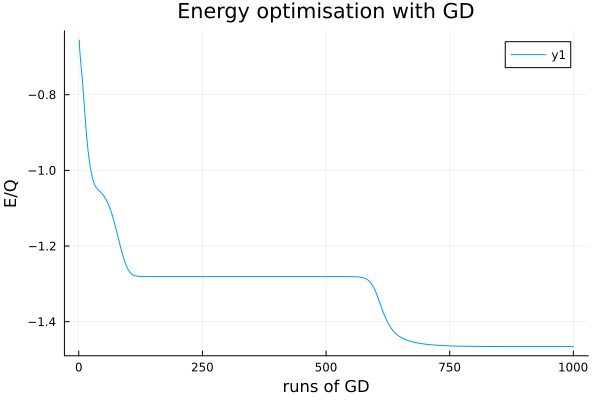

In [10]:
# gradient descent
eta = 0.1
opt_energy_gd = []
thetas = thetas_init
for i in 1:1000 # steps
    gradient!(grad_array_compiled, simulation_tape, thetas)
    thetas .-= eta * grad_array_compiled
    opt_energy_gd = push!(opt_energy_gd, lossfunction(thetas)/nq)
end
#println(thetas) #Why do the first few stay the same, while the end is strongly modified? Is this sth systematic?
println(lossfunction(thetas)/nq)
plot(opt_energy_gd)

plot!(title = "Energy optimisation with GD", xlabel = "runs of GD", ylabel = "E/Q")

In [11]:
 #ADAM (this is suboptimal because we recalculate the gradients)
# thetas = thetas_init
# opt_energy_adam = []

# opt_result = Optim.optimize(lossfunction, thetas, Adam(), Optim.Options(iterations=1000))
# thetas .= Optim.minimizer(opt_result)

# #println(thetas)  # Check the final optimized parameters
# println(lossfunction(thetas)/nq)  # Check the final optimized energy (similar to GD)

### Questions so far:
We expect an exact energy/qubit of -2.1 approximately for 16 qubits (Fig2), we are far off, so we are looking for possible error sources:
- Reducing the truncation does not change results significantly.
- Chosing a better optimiser than GD (tried ADAM) gives similar results.
- We have (2Q-1) non-Cliffords in the circuit so for Q=16 qubits, we have N=31 non-Cliffords already (this is quite high for a cl. simulation, state of the art is N<80 and Piotr used MPS with up to N=35)
- When we initialise the parameters, they are fixed to have the same values in every RZZ and RZ layer, but later this changes during optimization. How can we keep this constraint during the optimization?
- We get the warning `WARNING: redefinition of constant Main.simulation_tape.`, should we keep doing this like in the example notebooks?

The goal so far is to compare to the paper if we can get somewhat similar results. The target circuit `tfimqaoacircuit()` should be near-Clifford enough to give us similar results to the exact expectation values of the paper.

### MCMC - generating the set of test states
- generate a set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$
- the initial state `initialize_mcmc_circuit()` is chosen by finding a near-Clifford circuit wrt the target circuit `tfimqaoacircuit()`
- update steps: randomly pick $n_p$ pairs of the circuits RZ rotations (RZZ are also just RZ rotations with CNOT before and after)
- in each pair keep one gate as non-Clifford and replace the other by $S^n$, where $S$ is the $\pi/2$ rotation gate, take an integer power $n$ (which we choose by sampling)
- this "pair mechanism" makes sure we don't replace too many gates with Clifford gates, which would lead to a larger distance from the target state $\ket{\psi}$.

In [12]:
function initialize_mcmc_circuit(circuit, nqubits::Integer, nlayers::Integer)
    # Choose nq*nl/2 random Pauli rotations to replace with Clifford R_Z(k_p π/2) gates.
    # The replacements are random for the whole circuit and don't repeat for each layer.

    # Get indices of Pauli rotations
    z_rot_indices = [i for i in eachindex(circuit) if isa(circuit[i], PauliRotation)]

    num_to_replace = div(nqubits * nlayers, 2)
    Random.shuffle!(z_rot_indices)
    indices_replaced = z_rot_indices[1:num_to_replace]
    #println("Indices to replace: ", indices_to_replace)

    # Extract qubit indices for gates to be replaced
    qubits = [circuit[i].qinds for i in indices_replaced]
    #println("Qubits involved: ", qubits)

    # Create a modified circuit
    new_circuit = copy(circuit)

    # Replace selected R_Z rotations with Clifford R_Z(k_p π/2)
    for (j, i) in enumerate(indices_replaced)
        k_p = rand(0:3)  # Randomly select k_p from {0,1,2,3} ( no clear indication in the paper)
        if length(qubits[j]) == 1
            new_circuit[i] = PauliRotation(:Z, qubits[j], k_p * π/2)  # Replace with Clifford rotation
        else
            new_circuit[i] = PauliRotation([:Z, :Z], qubits[j], k_p * π/2)  # Replace with Clifford rotation
        end
    end

    return new_circuit, indices_replaced
end

initialize_mcmc_circuit (generic function with 1 method)

In [13]:
init_circuit, indices_replaced = initialize_mcmc_circuit(circuit, nq, nl) #check
init_circuit
indices_replaced

4-element Vector{Int64}:
  1
 29
 26
  3

In [14]:
#test the init function:
println(circuit)
println(init_circuit)   

Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), PauliRotation([:Z], [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), PauliRotation([:Z], [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [2, 3]), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), p

## Under construction from here on
- idea is to have only one function for the MCMC

In [15]:
# Define the function to apply circuit updates
function proposal_tfimqaoacircuit(target_circuit::Vector{Gate},init_circuit::Vector{Gate},indices_replaced::Vector{Int},np::Integer=2)    
    # Identify all Pauli Z rotations in the circuit (includes RZZ) (Pauli Z are only the non-Cifford's here)
    z_rot_indices = [i for i in eachindex(init_circuit) if isa(init_circuit[i], PauliRotation)]

    println("Z rotation indices: ", z_rot_indices)
    println("Indices replaced: ", indices_replaced)  
    # Ensure we have enough pairs
    if length(indices_replaced) < np
        error("Not enough frozen Pauli rotations in the initialized MCMC circuit to select the value of pairs.")
    end

    # Shuffle and select n_p pairs
    Random.shuffle!(z_rot_indices)
    Random.shuffle!(indices_replaced)
    selected_pairs = [(z_rot_indices[i], indices_replaced[i]) for i in 1:np] #
    
    println("Selected pairs: ", selected_pairs) 
    
    #replace left element (non-Clifford) with a Clifford gate S^n,sample n

    #choose first element of each pair and replace with Clifford gate
    for (i, j) in selected_pairs
        qubits = init_circuit[i].qinds
        k_p = rand(0:3)  # Randomly select k_p from {0,1,2,3} ( sample this from prob. distribution!)
        if length(qubits) == 1
            init_circuit[i] = PauliRotation(:Z, qubits, k_p * π/2)  # Replace with Clifford rotation
        else
            init_circuit[i] = PauliRotation([:Z, :Z], qubits, k_p * π/2)  # Replace with Clifford rotation
        end
    end
    
    #reset the right element to the one of the target circuit
    for (i, j) in selected_pairs 
        qubits = init_circuit[j].qinds
        init_circuit[j] = target_circuit[j] 
    end


#check 
    println("Circuit after first replacement: ", circuit)
    # now we need to "SWAP" the selected pairs according to the details of the paper
    #return new_circuit
end

proposal_tfimqaoacircuit (generic function with 2 methods)

In [16]:
println("Initial circuit: ", init_circuit)

Initial circuit: Gate[FrozenGate(PauliRotation([:Z, :Z], [1, 2]), parameter = 3.14), PauliRotation([:Z, :Z], [3, 4]), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), parameter = 1.57), CliffordGate(:S, [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), PauliRotation([:Z], [1]), FrozenGate(PauliRotation([:X], [1]), parameter = 1.57), CliffordGate(:S, [1]), CliffordGate(:S, [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), PauliRotation([:Z], [2]), FrozenGate(PauliRotation([:X], [2]), parameter = 1.57), CliffordGate(:S, [2]), CliffordGate(:S, [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), PauliRotation([:Z], [3]), FrozenGate(PauliRotation([:X], [3]), parameter = 1.57), CliffordGate(:S, [3]), CliffordGate(:S, [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), PauliRotation([:Z], [4]), FrozenGate(PauliRotation([:X], [4]), parameter = 1.57), CliffordGate(:S, [4]), PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), FrozenGate(PauliR

In [17]:
proposal_tfimqaoacircuit(init_circuit, indices_replaced,2) #check

MethodError: MethodError: no method matching proposal_tfimqaoacircuit(::Vector{Gate}, ::Vector{Int64}, ::Int64)
The function `proposal_tfimqaoacircuit` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  proposal_tfimqaoacircuit(::Vector{Gate}, !Matched::Vector{Gate}, !Matched::Vector{Int64})
   @ Main ~/julia_scripts/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sdnNjb2RlLXJlbW90ZQ==.jl:2
  proposal_tfimqaoacircuit(::Vector{Gate}, !Matched::Vector{Gate}, !Matched::Vector{Int64}, !Matched::Integer)
   @ Main ~/julia_scripts/pp-em/cdr/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sdnNjb2RlLXJlbW90ZQ==.jl:2


In [18]:
#short check that our replacements FrozenGates[PauliRotation[]] are not PauliRotations anymore
println(init_circuit[11] isa PauliRotation)
println(init_circuit[11] isa FrozenGate)

true
false


Next steps: 
- finish the proposal function (page 7, Appendix B of paper)
- define the MH algorithm
- merge everything into one MCMC function